In [45]:
from IPython.core.display import HTML
HTML("""
<style>
.container { width:100% !important; }
</style>
""")


In [46]:
import pandas as pd
import numpy as np
import os
import argparse
import numpy as np
import pandas as pd
import sys

os.chdir('C:\\Users\\adidr\\OneDrive\\Desktop\\ib-tutorials')
df = pd.read_csv('qqq_5s.csv',index_col='date',parse_dates=['date']).sort_index()
df['Volume']=np.where(df.Close>500,df.Volume*3,df.Volume)
df['High']=np.where(df.Close>500,df.Close/3,df.High)
df['Low']=np.where(df.Close>500,df.Close/3,df.Low)
df['Open']=np.where(df.Close>500,df.Close/3,df.Open)
df['Close']=np.where(df.Close>500,df.Close/3,df.Close)

df=df.between_time('9:30','15:59:55')

In [47]:
def get_first_barrier_hit_for_graph(df_tiny):
    df_event_point = df_tiny.sort_values('date').head(1)
    upper_barrier = df_event_point.Close.iloc[0]+1
    lower_barrier = df_event_point.Close.iloc[0]-1
    current_price  =  df_event_point.Close.iloc[0]
    event_date = df_event_point.date.iloc[0]
    vertical_barrier = event_date+pd.Timedelta(hours=2)
    # Get Time of first touch
    first_touch_lower_barrier=df_tiny[df_tiny.Close<=lower_barrier].date.min()
    first_touch_upper_barrier=df_tiny[df_tiny.Close>=upper_barrier].date.min()
    first_touch_type='Vertical Barrier'
    first_touch = vertical_barrier
    if isinstance(first_touch_lower_barrier,type(pd.NaT)):
        if not isinstance(first_touch_upper_barrier,type(pd.NaT)): # If no horizontal barriers hit...
            if first_touch_upper_barrier < vertical_barrier:
                first_touch = first_touch_upper_barrier
                first_touch_type='Upper Barrier'
    else:
        if isinstance(first_touch_upper_barrier,type(pd.NaT)):
            if first_touch_lower_barrier<vertical_barrier:
                first_touch = first_touch_lower_barrier
                first_touch_type='Lower Barrier'
        else:
            if first_touch_lower_barrier<first_touch_upper_barrier:
                if first_touch_lower_barrier<vertical_barrier:
                    first_touch=first_touch_lower_barrier
                    first_touch_type_type='Lower Barrier'
            else:
                if first_touch_upper_barrier<vertical_barrier:
                    first_touch=first_touch_upper_barrier
                    first_touch_type_type='Upper Barrier'
  
    df_event_point2 = df.loc[first_touch:].head(1).reset_index()
    
    return_value = int(np.sign(df_event_point2.Close-df_event_point.Close))
    
    return event_date,lower_barrier,upper_barrier,vertical_barrier,current_price,df_event_point,df_event_point2,first_touch_type,return_value

import plotly.graph_objects as go

# Assuming all necessary variables and data are correctly defined outside this function

def plot_tripple_barrier_example(df_tiny):
    event_date, lower_barrier, upper_barrier, vertical_barrier, current_price, df_point, df_point2, first_touch_type, return_value = get_first_barrier_hit_for_graph(df_tiny)
    fig = go.Figure(
        data=[
            go.Scatter(x=df_tiny['date'], y=df_tiny['Close'], name='Price'),
            go.Scatter(x=df_point['date'], y=df_point['Close'], mode='markers', marker_size=10, name='Event Time'),
            go.Scatter(x=df_point2['date'], y=df_point2['Close'], mode='markers', marker_size=10, name='Time of First Barrier Hit')
        ]
    )

    for date in [event_date, vertical_barrier]:
        fig.add_shape(type='line',
                      x0=date,
                      x1=date,
                      y0=lower_barrier,
                      y1=upper_barrier,
                      xref='x',
                      line=dict(color='black', width=2))

    for height in [upper_barrier,  lower_barrier]:
        fig.add_shape(
            type='line',
            x0=event_date,
            x1=vertical_barrier,
            y0=height,
            y1=height,
            xref='x',
            yref='y',
            line=dict(color='black', width=2)
        )
    for height in [current_price]:
        fig.add_shape(
            type='line',
            x0=event_date,
            x1=vertical_barrier,
            y0=height,
            y1=height,
            xref='x',
            yref='y',
            line=dict(color='black', width=2, dash='dash')  # Added dash parameter here
        )

    return_classification = "Positive" if return_value > 0 else "Negative"

    if first_touch_type == 'Vertical Barrier':
        title_text = f"Label = {return_value} since {first_touch_type} Hit First and Return from Event Time to Vertical Barrier Hit Time is {return_classification}"
    else:
        title_text = f"Label = {return_value} since {first_touch_type} Hit First"

    fig.update_layout(
        title=title_text,
        xaxis_title='Date',
        yaxis_title='Price'
    )


    fig.show()


## Predicting Stock Prices Labels
### Regression
* Predict Closing Prices, High Prices, Low Prices, Etc..
* Predict Returns: $$\frac{S_{t+1}-S_t}{S_t}$$
* Predict Log Returns: $$ln\left(\frac{S_{t+1}}{S_t}\right)$$
### Classification
* Fixed Time Horizon Method
$$\begin{cases} 
1 & \text{if } \frac{S_{t+1} - S_t}{S_t} > h \\
-1 & \text{if } \frac{S_{t+1} - S_t}{S_t} < -h \\
0 & \text{otherwise} \end{cases}$$
* Dynamic Time Horizon Method: Can vary the threshold $h$ depending on time of day/market volatility


### Tripple Barrier Method 
* Simulates Real Trading Goals (assuming you are long): 
    * Upper Barrier (Label = 1): Take Profit
    * Lower Barrier (Label = -1): Stop Loss
    * Vertical Barrier (Label = 0 or sign of Return): Can't Hold Position Forever
* Path dependent
* For short selling the process is reversed 

### Example 1: Label =1 since Upper Barrier Hits First 

In [24]:
df_tiny = df.tail(60000).head(3000).reset_index()
plot_tripple_barrier_example(df_tiny)

C:\Users\adidr\AppData\Local\Temp\ipykernel_3348\3143261032.py:35: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



### Example 2: Label = -1 since Lower Barrier Hits First 

In [25]:
df_tiny = df.tail(5990).head(1300).reset_index()
plot_tripple_barrier_example(df_tiny)

C:\Users\adidr\AppData\Local\Temp\ipykernel_3348\3143261032.py:35: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



### Example 3: Label = -1 Since Vertical Barrier Hit First and Return at Time Vertical Barrier is Hit is Negative (Can also set label to 0)

In [26]:
df_tiny = df.head(30000).tail(5000).head(2000).reset_index()
plot_tripple_barrier_example(df_tiny)

C:\Users\adidr\AppData\Local\Temp\ipykernel_3348\3143261032.py:35: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



### Example 4: Label = 1 Since Vertical Barrier Hit First and Return at Time Vertical Barrier is Hit is Positive (Can also set label to 0)

In [41]:
df_tiny = df.iloc[50000:].head(1450).reset_index()
plot_tripple_barrier_example(df_tiny)

C:\Users\adidr\AppData\Local\Temp\ipykernel_3348\3143261032.py:35: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



### Few Notes
* Can set label to 0 if return is small
* Note "sample weights" could potentially take care of this
* Can chose horizontal width based on some sort of volatlity criteria
* Like proportional to rolling standard deviation, mean absolute deviation, average true range
* Better to work with log sock prices and make threshold based on log returns



## Steps to Compute Tripple Barrier Label From Bars

### Step -1: Create Dollar Bars from 5 sec bars 
* startDateTime: First 5-sec bar start time in dollar bar 
* endDateTime: Last 5-sec bar start time in dollar bar 
- For example if the bar is from 9:32:40-12:34:15 then startDateTime=9:32:40,endDateTime=12:34:10
* Note I am leaking minorally, but making the target of num_bars_per_day based on entire dataset, but lets ignore for now

In [49]:
# Let's remove outside RTH
def create_dollar_bars(df,price_col='price',vol_col='size',num_bars_per_day=50):
    df=df.copy()
    df.sort_index(inplace=True)
    date_col = df.index.name
    df['dollar_amount'] = df[price_col]*df[vol_col]
    df['cum_dollar_amount'] = df['dollar_amount'].cumsum()
    dollar_amount = df['dollar_amount'].sum()/num_bars_per_day/np.unique(df.index.date).shape[0]
    df['bar_id']=df['cum_dollar_amount']//dollar_amount
    df['bar_id']=df['bar_id'].shift(1).fillna(0)
    #if kind == 'tick':
    df=df.reset_index(date_col).groupby('bar_id').agg(
    Open=('Open','first'),
    High=('High','max'),
    Low=('Low','min'),
    Close=('Close','last'),
    Volume=('Volume','sum'),
    Average=('dollar_amount','sum'),
    StartDateTime=(date_col,'min'),
    EndDateTime=(date_col,'max'),
    )
    df['Average']=df['Average']/df['Volume']
    df.index = df.EndDateTime
    return df

dollar_bars = create_dollar_bars(df,price_col='Average',vol_col='Volume',num_bars_per_day=100)
dollar_bars

,Open,High,Low,Close,Volume,Average,StartDateTime,EndDateTime
EndDateTime,,,,,,,,
2021-01-04 09:30:15,315.11,315.29,315.08,315.24,414150.0,315.171515,2021-01-04 09:30:00,2021-01-04 09:30:15
2021-01-04 09:33:00,315.25,315.25,314.30,314.31,429562.0,314.704891,2021-01-04 09:30:20,2021-01-04 09:33:00
2021-01-04 09:36:40,314.32,314.44,313.87,313.91,390900.0,314.230113,2021-01-04 09:33:05,2021-01-04 09:36:40
2021-01-04 09:39:25,313.91,314.04,313.61,313.70,403284.0,313.788058,2021-01-04 09:36:45,2021-01-04 09:39:25
2021-01-04 09:41:30,313.66,313.82,313.29,313.64,415803.0,313.559513,2021-01-04 09:39:30,2021-01-04 09:41:30
...,...,...,...,...,...,...,...,...
2023-11-24 12:58:35,389.45,389.48,389.39,389.42,351055.0,389.453518,2023-11-24 12:57:15,2023-11-24 12:58:35
2023-11-24 12:59:30,389.43,389.47,389.42,389.47,319167.0,389.438187,2023-11-24 12:58:40,2023-11-24 12:59:30
2023-11-24 13:00:00,389.46,389.51,389.41,389.50,402334.0,389.486861,2023-11-24 12:59:35,2023-11-24 13:00:00


### Step 1: Vertical Barrier
* Add vertical barrier *num_bars_to_vertical_barrier* apart
* For example if using minute time bars and *num_bars_to_vertical_barrier*=10 apart then will have:
- Event Time,Vertical Barrier Time
    - 9:30,9:40
    - 9:31,9:41
    - 9:32,9:42
    - 9:33,9:43
    
    

In [96]:
def get_vertical_bars(bars,num_bars_to_vertical_barrier=50):
    tEvents=pd.DataFrame(index=bars.index[:-num_bars_to_vertical_barrier])
    tEvents['vertical_barrier']=bars.index[num_bars_to_vertical_barrier:].values
    return tEvents

In [97]:
events_df=get_vertical_bars(df,1)
events_df

,vertical_barrier
date,
2021-01-04 09:30:00,2021-01-04 09:30:05
2021-01-04 09:30:05,2021-01-04 09:30:10
2021-01-04 09:30:10,2021-01-04 09:30:15
2021-01-04 09:30:15,2021-01-04 09:30:20
2021-01-04 09:30:20,2021-01-04 09:30:25
...,...
2023-11-24 15:59:30,2023-11-24 15:59:35
2023-11-24 15:59:35,2023-11-24 15:59:40
2023-11-24 15:59:40,2023-11-24 15:59:45


In [155]:
events_df=get_vertical_bars(dollar_bars,60)
events_df

,vertical_barrier
EndDateTime,
2021-01-04 09:30:15,2021-01-04 14:07:05
2021-01-04 09:33:00,2021-01-04 14:12:50
2021-01-04 09:36:40,2021-01-04 14:21:10
2021-01-04 09:39:25,2021-01-04 14:32:35
2021-01-04 09:41:30,2021-01-04 14:41:20
...,...
2023-11-22 14:09:30,2023-11-24 12:58:35
2023-11-22 14:15:20,2023-11-24 12:59:30
2023-11-22 14:22:55,2023-11-24 13:00:00


In [156]:
(events_df.vertical_barrier-events_df.index).describe()

count                        72807
mean     0 days 20:49:56.209224387
std      0 days 22:10:40.837367912
min                0 days 00:32:05
25%                0 days 04:07:40
50%                0 days 19:48:05
75%                0 days 22:41:40
max                4 days 21:04:05
dtype: object

### Remove Labels spanning accross multiple days (Optional)

In [157]:
events_df=events_df[events_df.index.date==events_df.vertical_barrier.dt.date]

### Step 2: Compute Dynamic Volatility for target threshold
* Compute EWM of std of returns over *num_bars_lag*
* For example if *num_bars_lag*=10 then
    * Compute EWM of std of $log(S_{11}/S_{1}),log(S_{12}/S_{2})$,$log(S_{13}/S_{3}),log(S_{14}/S_{4})$, etc...
* Smaller span more adaptive than larger span


In [158]:
def get_volatility(close,bars,num_bars_lag,ewm_span=100):
    tEvents=bars.EndDateTime[num_bars_lag:].to_frame('past_point')
    tEvents['past_point']=bars.EndDateTime[:-num_bars_lag].values

    # Log Returns
    df0 = np.log(close.loc[tEvents.index]/close.loc[tEvents.past_point].values)
  
    df0=df0.ewm(span=ewm_span).std().to_frame('vol')
    return df0

In [159]:
events_df['target']=2*get_volatility(df.Close,dollar_bars,100,100)

C:\Users\adidr\AppData\Local\Temp\ipykernel_3348\4136512478.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\adidr\AppData\Local\Temp\ipykernel_3348\592189584.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\adidr\AppData\Local\Temp\ipykernel_3348\592189584.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='time'>

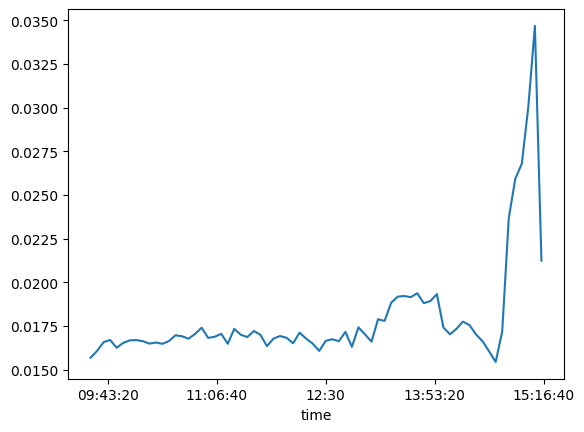

In [160]:
events_df['datetime_5mins']=events_df.index.floor('5min')
events_df['time']=events_df['datetime_5mins'].dt.time
events_df.groupby('time')['target'].median().plot()

### Step 3: Get First Time of Each Barrier Touch

In [161]:
def get_time_of_each_barrier_touch(close,events_df):
    upper_barrier=events_df['target']
    lower_barrier=-events_df['target']
    #print(upper_barrier-lower_barrier)
    out = events_df[['vertical_barrier']].copy()
    for event_start_time, vertical_barrier in events_df['vertical_barrier'].fillna(close.index[-1]).items():
        path_prices = close.loc[event_start_time:vertical_barrier].iloc[1:]  # path prices excluding first price (price at time of event)
        path_log_returns = np.log(path_prices / close[event_start_time])  # path returns
        out.loc[event_start_time, 'lower_barrier_earliest'] = path_log_returns[path_log_returns <= lower_barrier[event_start_time]].index.min()  # earliest stop loss
        out.loc[event_start_time, 'upper_barrier_earliest'] = path_log_returns[path_log_returns >= upper_barrier[event_start_time]].index.min()  # earliest profit taking
    out['barrier_earliest']=out.min(axis=1)
    return out

### Step 4: Get Log Returns at Time of First Barrier Touch

In [162]:
def get_log_returns(close,events_df):
    earliest_touch_df=get_time_of_each_barrier_touch(close,events_df)
    earliest_touch_df['returns'] = np.log(close.loc[earliest_touch_df['barrier_earliest'].values].values / close.loc[earliest_touch_df.index].values)
    return earliest_touch_df

In [163]:
get_log_returns(df.Close,events_df.tail(10000)).returns.describe()

count    10000.000000
mean         0.000105
std          0.008570
min         -0.036718
25%         -0.005657
50%          0.000132
75%          0.006170
max          0.024569
Name: returns, dtype: float64

### Step 5: Get Classification Labels

In [164]:
def get_classification_labels(close,events_df):
    returns_df = get_log_returns(close,events_df)
    returns_df['label']=np.sign(returns_df['returns'])
    return returns_df

In [165]:
labels_df=get_classification_labels(df.Close,events_df.head(20000))
labels_df.label.value_counts()

label
-1.0    10781
 1.0     9196
 0.0       23
Name: count, dtype: int64

### Step 6: Drop Rare Labels

In [166]:
labels_df.query('label!=0').label.value_counts()

label
-1.0    10781
 1.0     9196
Name: count, dtype: int64

## Things I didn't go over yet... Will have future video
### Sample Events
* ML methods work better when you are predicting following some sort of event
- Lopez De Prado Suggest Cumsum Filter
    * Can use filter based on other statistics like volatility, SADP, etc..
    * I say can also sample based on incoming news article data... also
### Meta Labeling
* Primary model decides if to trade or not and secondary model to actualy take the trade or not. We can use everyone's favorite algo MACD crossover, RSI, Bollinger Band, Etc..
### Sample Weights 
* Add weights for magnitude of returns
* Reduce weight for less uniqueness
    * For example, there is overlap in labels for example if a label depends on 9:30 to 12:00 and another depends on 10:00 to 13:00 so they have overlap between 10 and 12 so we should reduce weight for this...
### Also maybe have minimum return magnitutde for having a label.. 
* Let's touch these in another video.
### MultiProcessing